# Modulo 4

Tomamos como baseline una regresión logística utilizando la regularización con l2 y buscamos un modelo no lineal para batirlo. 

## 0. Preparación

Cargamos los datos, separamos, igual que en el módulo anterior.

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
from sklearn.compose import ColumnTransformer

In [2]:
import sys
print(sys.executable)

/mnt/d/zrive-ds/.venv/bin/python


In [3]:
final_directory = "/mnt/d/zrive-ds/src/module_3/data/feature_frame_filtered.csv"
df = pd.read_csv(final_directory)

In [ ]:
# Sort the DataFrame by 'order_date'
df_sorted = df.sort_values(by='order_date')

# Calculate the number of unique orders
total_orders = df_sorted['order_id'].nunique()
# Determine the number of orders for each split
train_orders_count = int(total_orders * 0.7)
validation_orders_count = int(total_orders * 0.2)

# Split the sorted DataFrame into train, validation, and test sets based on order counts
train_df = df_sorted[df_sorted['order_id'].isin(df_sorted['order_id'].unique()[:train_orders_count])]
validation_df = df_sorted[df_sorted['order_id'].isin(df_sorted['order_id'].unique()[train_orders_count:train_orders_count + validation_orders_count])]
test_df = df_sorted[df_sorted['order_id'].isin(df_sorted['order_id'].unique()[train_orders_count + validation_orders_count:])]

print(f"Train set size: {train_df.shape}")
print(f"Validation set size: {validation_df.shape}")
print(f"Test set size: {test_df.shape}")

X_train = train_df.drop("outcome", axis = 1)
y_train = train_df["outcome"]

X_validation = validation_df.drop("outcome", axis = 1)
y_validation = validation_df["outcome"]

X_test = test_df.drop("outcome", axis = 1)
y_test = test_df["outcome"]

Train set size: (1446691, 27)
Validation set size: (466762, 27)
Test set size: (250500, 27)


In [5]:
def plot_metrics(
    model_name: str,
    y_pred: pd.Series,
    y_test: pd.Series,
    target_precision: float = 0.05,
    figure = None,
):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1,2,figsize=(14,7))
    else:
        fig, ax = figure 

    ax[0].plot(recall, precision, label=f"{model_name}; AUC: {pr_auc:2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall Curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label = f"{model_name}; AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()

In [6]:
# List of numeric columns (you can adjust this list based on your data)
information_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]

target_col = ["outcome"]

binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]

label_cols = ["vendor", "product_type"]

numeric_cols = [col for col in df.columns.tolist() if col not in set(information_cols + binary_cols + label_cols + target_col)]

columns_train = binary_cols + numeric_cols

## 1. Baseline (regresión logística)

Cogemos el modelo lineal que daba mejores resultados. Buscamos batirlo con uno no lineal.

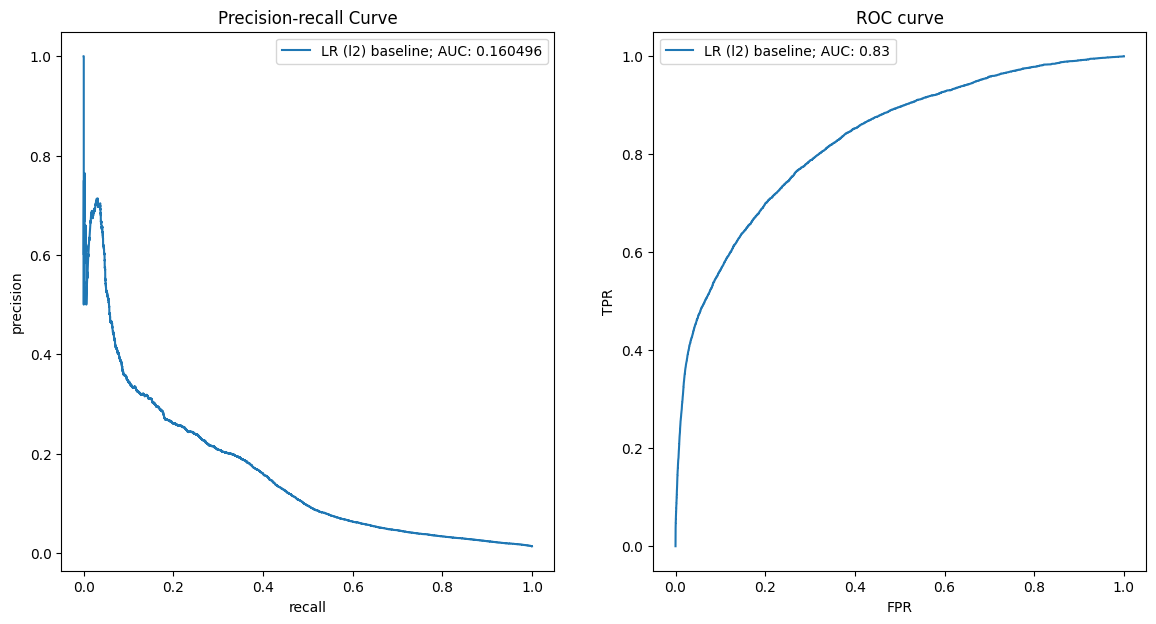

In [14]:
columns_train = binary_cols + numeric_cols
X_train_baseline = X_train[columns_train]

model_ridge_baseline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l2", C = 1e-6)
    )


# Train the model on the training data
model_ridge_baseline.fit(X_train_baseline, y_train)

X_validation_baseline = X_validation[columns_train]
y_validation_pred_baseline = model_ridge_baseline.predict_proba(X_validation_baseline)[:, 1]

y_train_pred_baseline = model_ridge_baseline.predict_proba(X_train_baseline)[:, 1]

fig1, ax1 = plt.subplots(1,2,figsize = (14,7))

plot_metrics("LR (l2) baseline",y_pred=y_validation_pred_baseline, y_test=y_validation, figure = (fig1, ax1))

## 2. Modelos no lineales

### 2.1 Random Forest 

Probamos primero sólo con las columnas numéricas y no las categóricas.

/mnt/d/zrive-ds/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/mnt/d/zrive-ds/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


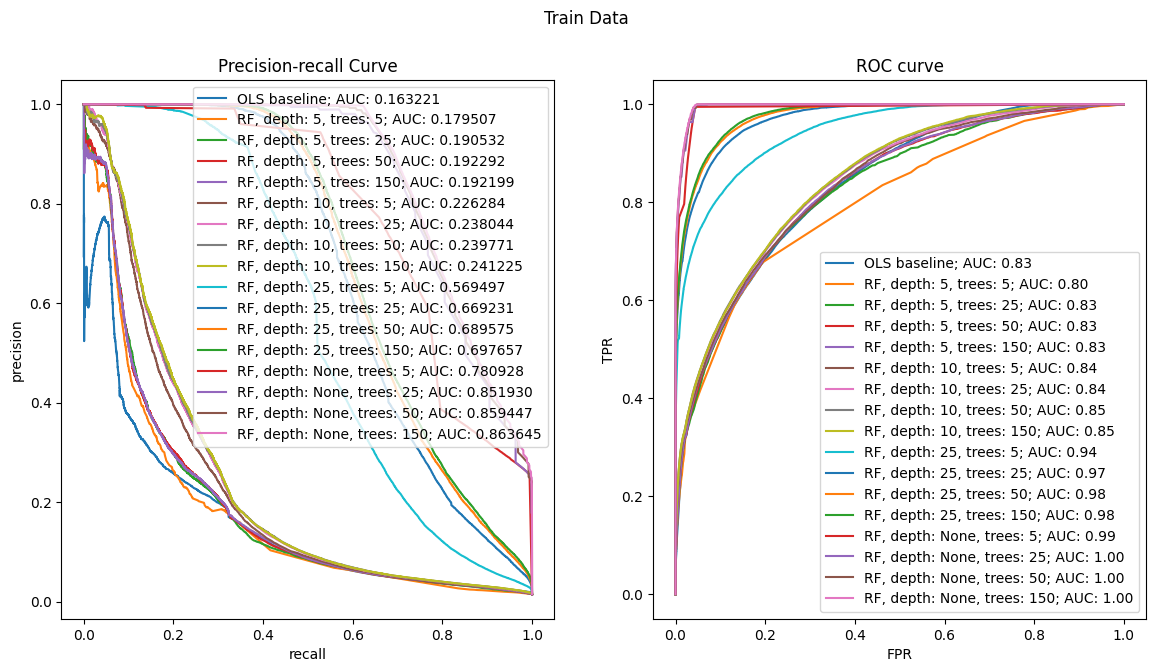

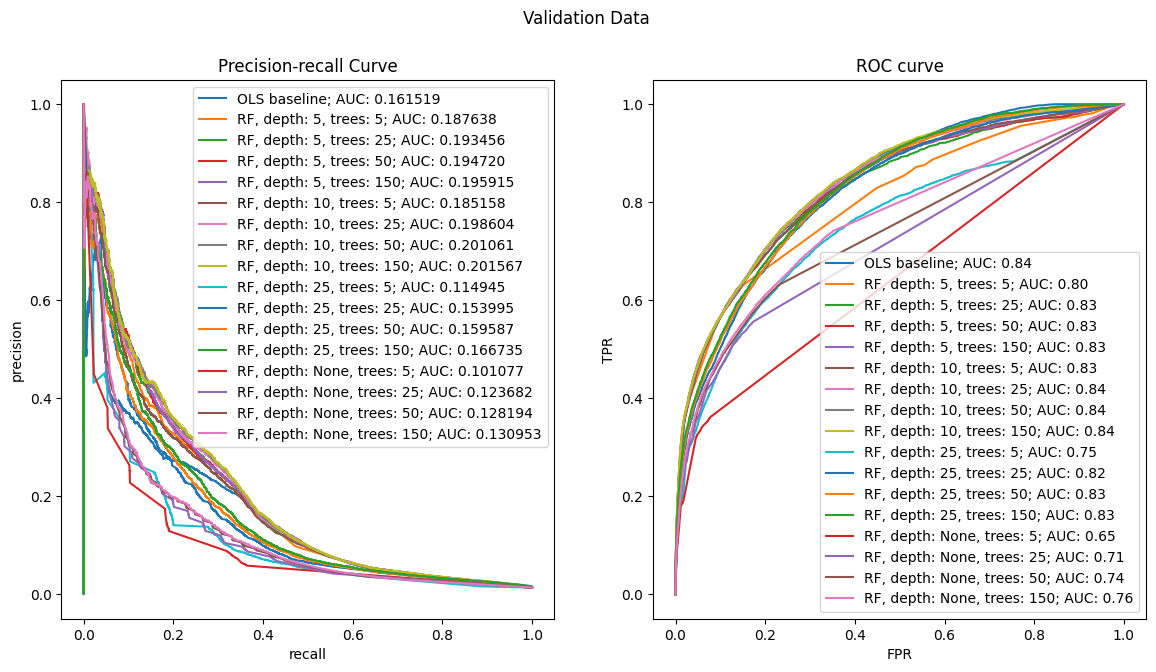

In [14]:
depths_RF = [5, 10, 25, None]
trees = [5, 25, 50, 150]

fig2, ax2 = plt.subplots(1,2,figsize = (14,7))
fig2.suptitle("Train Data")
fig3, ax3 = plt.subplots(1,2,figsize = (14,7))
fig3.suptitle("Validation Data")
plot_metrics("OLS baseline",y_pred=y_train_pred_linear, y_test=y_train, figure = (fig2, ax2))
plot_metrics("OLS baseline",y_pred=y_validation_pred_linear, y_test=y_validation, figure = (fig3, ax3))

for depth in depths_RF:
    for tree in trees: 
        
        if depth is None:
            model_RF = make_pipeline(
                StandardScaler(),
                RandomForestClassifier(n_estimators=tree, random_state=42)
            )
        else:
            model_RF = make_pipeline(
                StandardScaler(),
                RandomForestClassifier(n_estimators=tree, max_depth=depth, random_state=42)
            )        

        model_RF.fit(X_train[columns_train], y_train)

        y_train_pred_RF = model_RF.predict_proba(X_train[columns_train])[:, 1] #comprueblo que sale lo mismo 
        y_validation_pred_RF = model_RF.predict_proba(X_validation[columns_train])[:, 1]

        plot_metrics(f"RF, depth: {depth}, trees: {tree}",y_pred=y_train_pred_RF, y_test=y_train, figure = (fig2, ax2))
        plot_metrics(f"RF, depth: {depth}, trees: {tree}",y_pred=y_validation_pred_RF, y_test=y_validation, figure = (fig3, ax3))
        

Juntamos nuestro baseline con el mejor modelo de Random Forest.

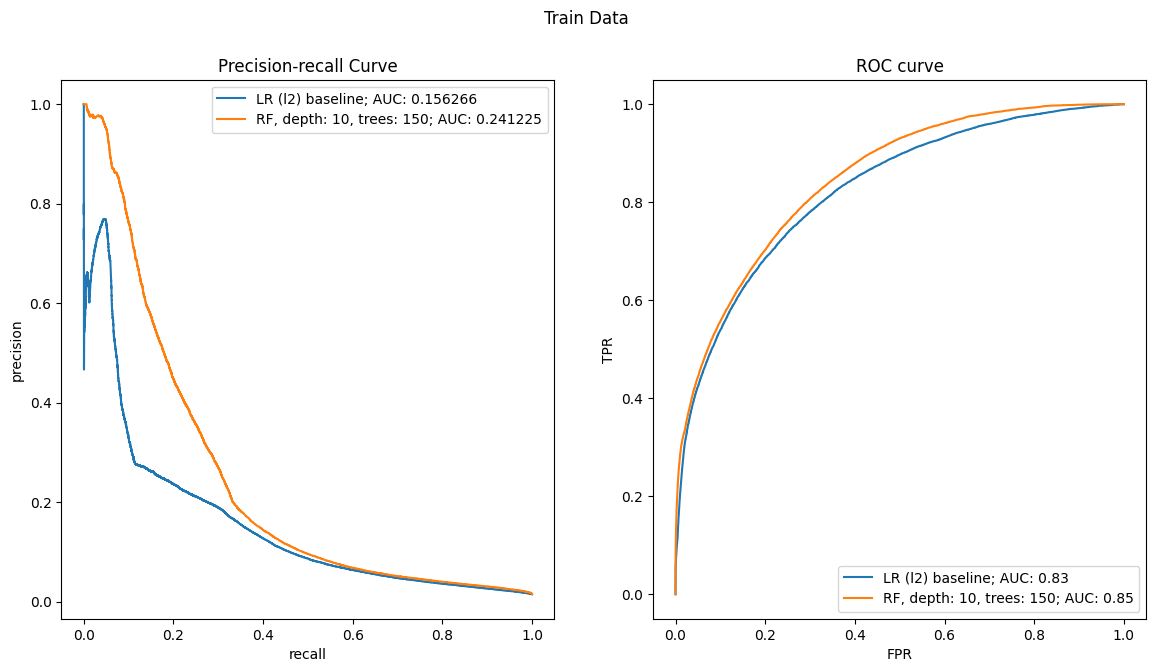

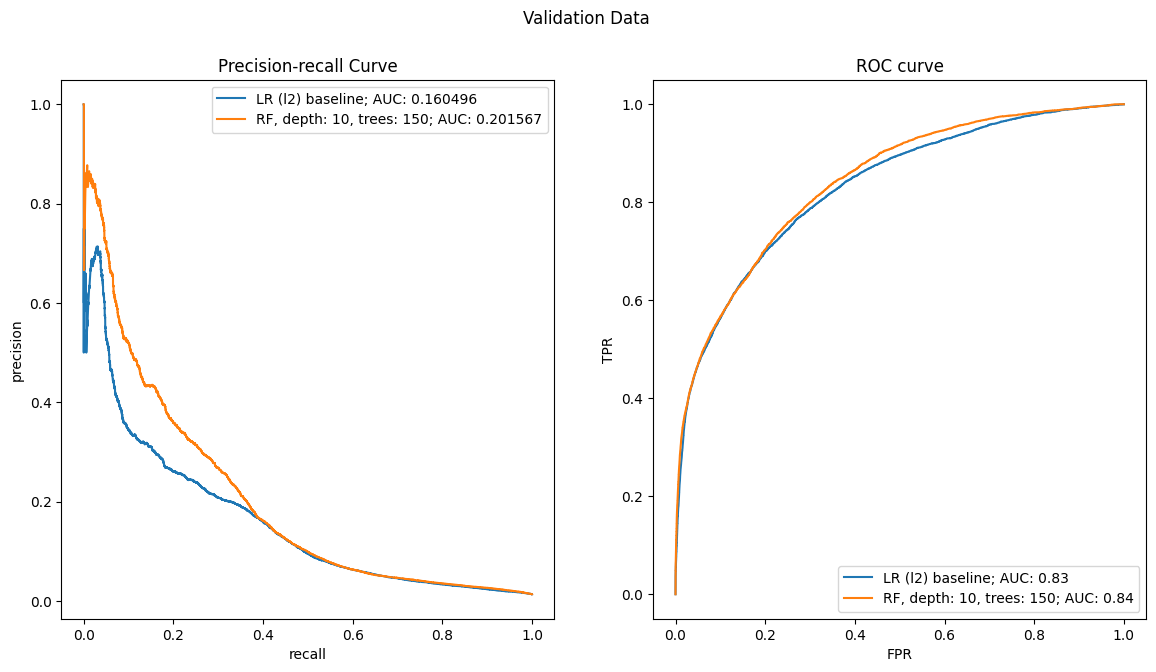

In [18]:
fig10, ax10 = plt.subplots(1,2,figsize = (14,7))
fig11, ax11 = plt.subplots(1,2,figsize = (14,7))
fig10.suptitle("Train Data")
fig11.suptitle("Validation Data")

plot_metrics("LR (l2) baseline",y_pred=y_train_pred_baseline, y_test=y_train, figure = (fig10, ax10))
plot_metrics("LR (l2) baseline",y_pred=y_validation_pred_baseline, y_test=y_validation, figure = (fig11, ax11))

model_RF = make_pipeline(
                StandardScaler(),
                RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
            )        

model_RF.fit(X_train[columns_train], y_train)
y_train_pred_RF = model_RF.predict_proba(X_train[columns_train])[:, 1]
y_validation_pred_RF = model_RF.predict_proba(X_validation[columns_train])[:, 1]

plot_metrics(f"RF, depth: 10, trees: 150",y_pred=y_train_pred_RF, y_test=y_train, figure = (fig10, ax10))
plot_metrics(f"RF, depth: 10, trees: 150",y_pred=y_validation_pred_RF, y_test=y_validation, figure = (fig11, ax11))



El modelo random forest sobre los datos de entrenamiento observamos lo predicho en teoría, el error de entrenamiento se va a cero según vamos aumentando la complejidad del modelo, usamos más árboles y permitimos más profundidad (hasta no limilarla, ```max_depth = None```). Cuando miramos a los datos de validación, vemos como según aumentamos la profundidad máxima no se aporta valor llevandolo al infinito o dejando muchos árboles por lo que parece que el mejor modelo lo encontramos en ```depth = 10, trees = 150```. Ese modelo consigue batir al baseline entrenado con OLS.

## 2.2 Gradiente

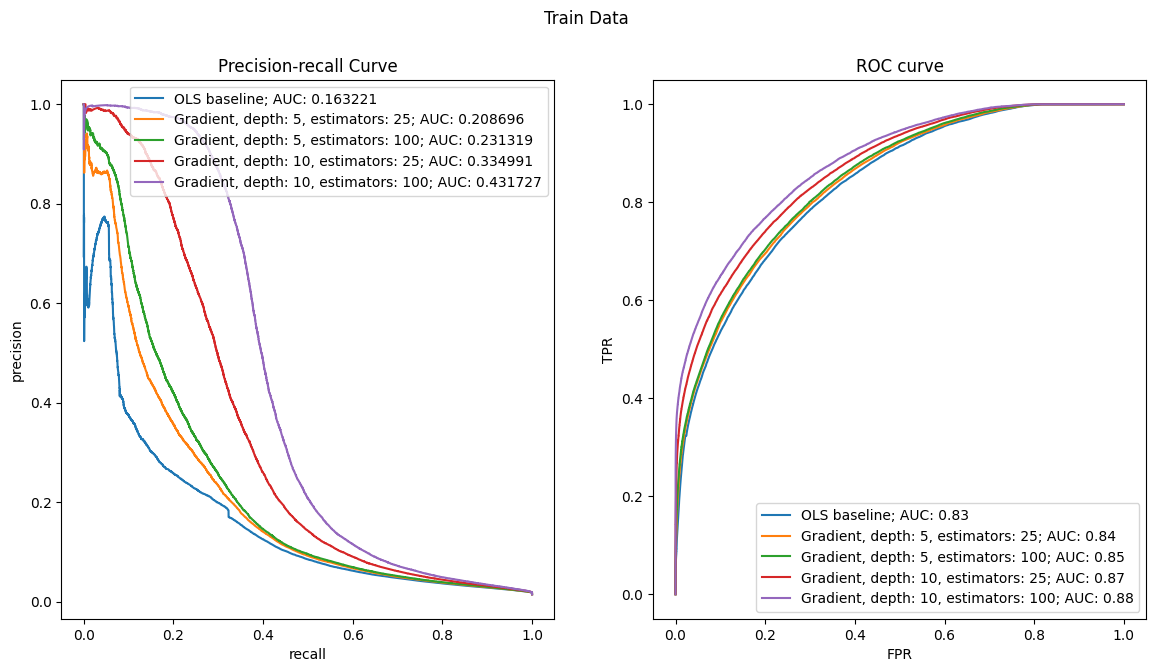

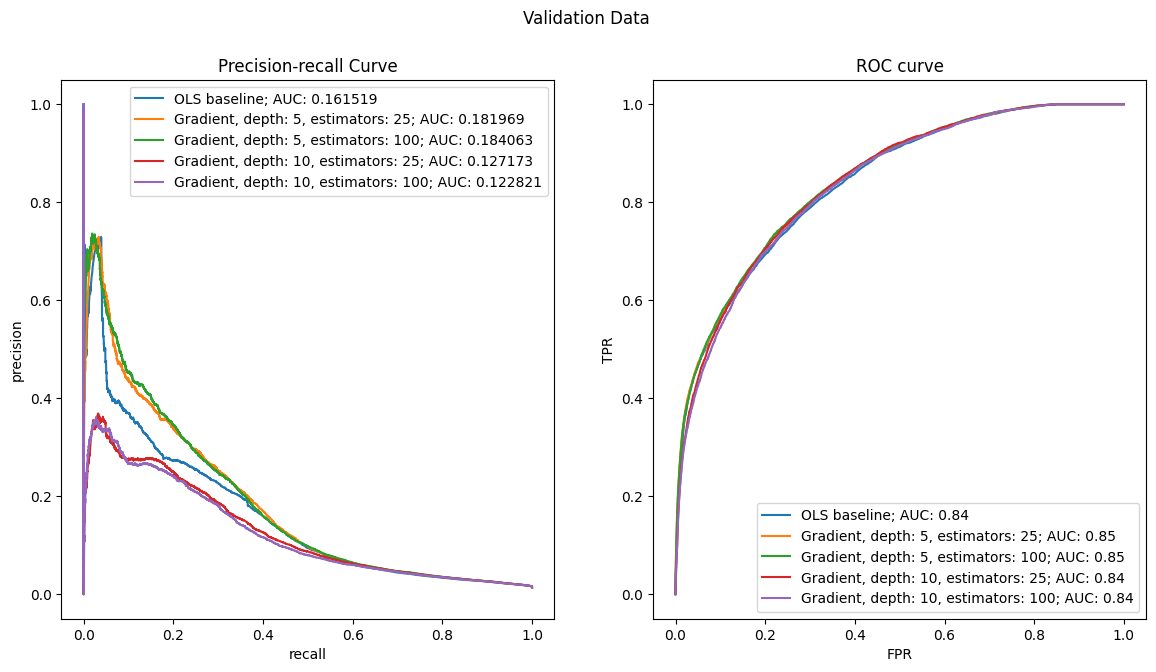

In [ ]:
depths_G = [5, 10]
estimators = [25, 100]

fig4, ax4 = plt.subplots(1,2,figsize = (14,7))
fig4.suptitle("Train Data")
fig5, ax5 = plt.subplots(1,2,figsize = (14,7))
fig5.suptitle("Validation Data")

plot_metrics("OLS baseline",y_pred=y_train_pred_linear, y_test=y_train, figure = (fig4, ax4))
plot_metrics("OLS baseline",y_pred=y_validation_pred_linear, y_test=y_validation, figure = (fig5, ax5))
for depth in depths_G:
    for estimator in estimators:
        model_G = make_pipeline(
            StandardScaler(),
            GradientBoostingClassifier(
                n_estimators=estimator,
                max_depth=depth, 
                random_state=42)
        ) 
        model_G.fit(X_train[columns_train], y_train)

        y_train_pred_G = model_G.predict_proba(X_train[columns_train])[:, 1]
        y_validation_pred_G = model_G.predict_proba(X_validation[columns_train])[:, 1]

        plot_metrics(f"Gradient, depth: {depth}, estimators: {estimator}",y_pred=y_train_pred_G, y_test=y_train, figure = (fig4, ax4))
        plot_metrics(f"Gradient, depth: {depth}, estimators: {estimator}",y_pred=y_validation_pred_G, y_test=y_validation, figure = (fig5, ax5))

Lo vemos también sólo con el mejor modelo de gradiente, para compararlo con el baseline.

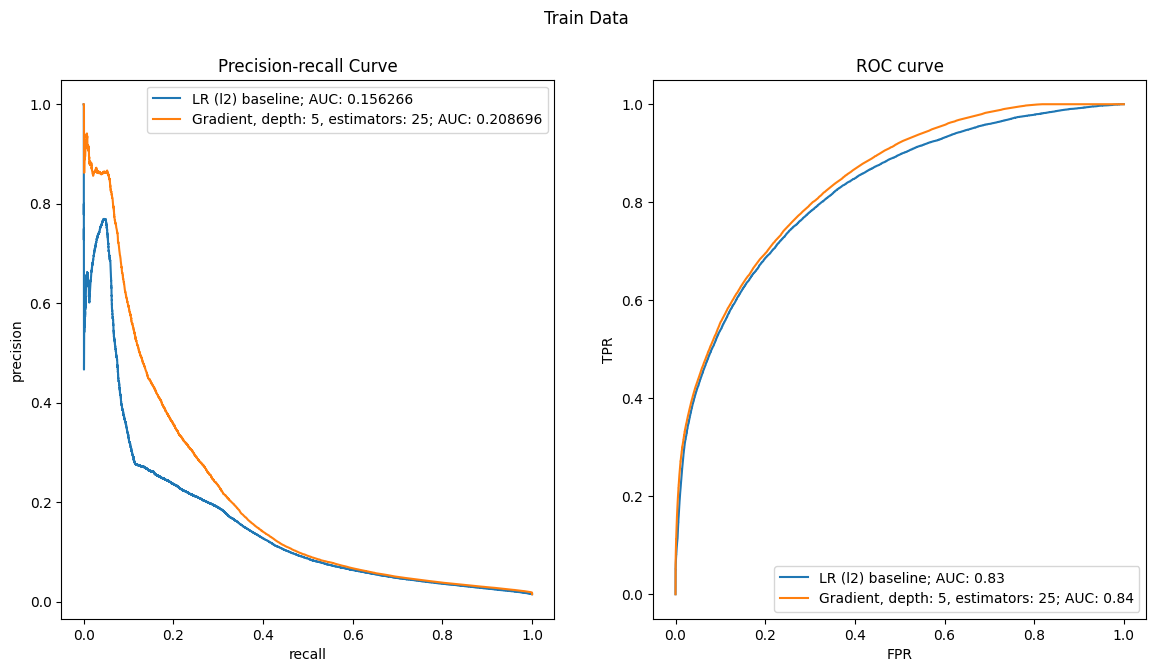

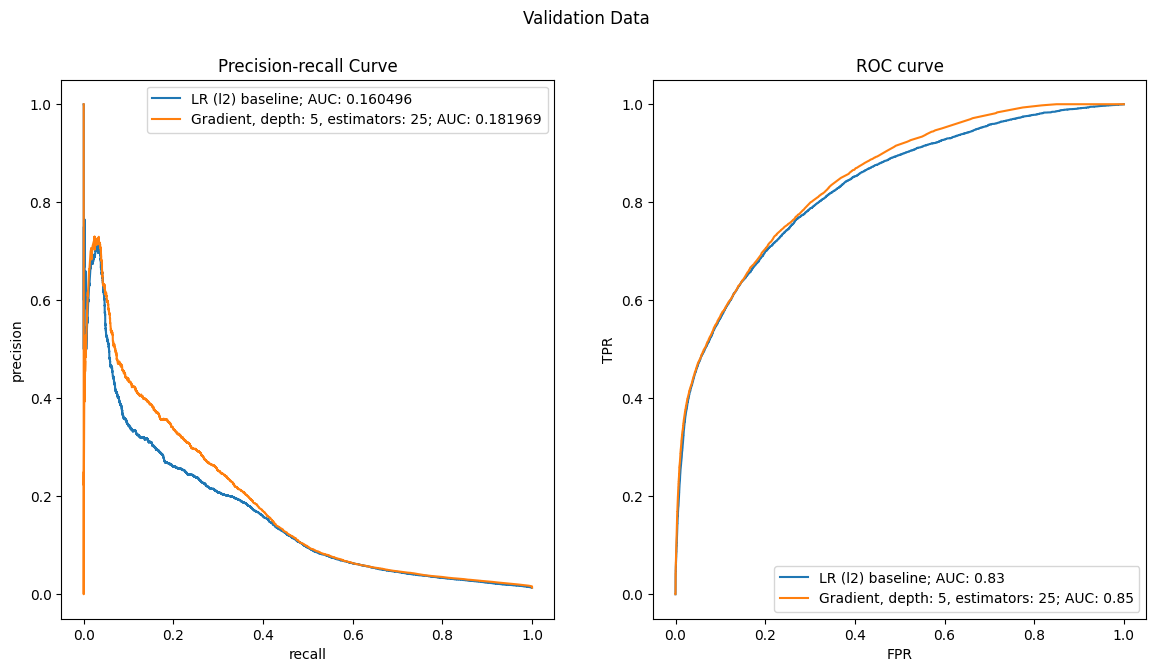

In [20]:
fig12, ax12 = plt.subplots(1,2,figsize = (14,7))
fig13, ax13 = plt.subplots(1,2,figsize = (14,7))
fig12.suptitle("Train Data")
fig13.suptitle("Validation Data")

plot_metrics("LR (l2) baseline",y_pred=y_train_pred_baseline, y_test=y_train, figure = (fig12, ax12))
plot_metrics("LR (l2) baseline",y_pred=y_validation_pred_baseline, y_test=y_validation, figure = (fig13, ax13))

model_G = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(
        n_estimators=25,
        max_depth=5, 
        random_state=42)
        )
model_G.fit(X_train[columns_train], y_train)

y_train_pred_G = model_G.predict_proba(X_train[columns_train])[:, 1]
y_validation_pred_G = model_G.predict_proba(X_validation[columns_train])[:, 1]

plot_metrics(f"Gradient, depth: 5, estimators: 25",y_pred=y_train_pred_G, y_test=y_train, figure = (fig12, ax12))
plot_metrics(f"Gradient, depth: 5, estimators: 25",y_pred=y_validation_pred_G, y_test=y_validation, figure = (fig13, ax13))

El modelo con el gradiente no consigue reducir el error de validación con más profundidad, sino todo lo contrario. Además el modelo con 25 da los mismos resultados que 100 (cuando la profundidad es 5), por lo que lo mantengo como el mejor modelo de gradiente ```depth = 5, estimators = 25``` dado que además tiene un error de entrenamiento y validación parecido. En las curvas ROC no se aprencian mejoras respecto al baseline lineal.

## 2.3 Neural network

W0000 00:00:1740425847.358087    7888 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.1028
Epoch 2/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0630
Epoch 3/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0619
Epoch 4/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0622
Epoch 5/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0620
Epoch 6/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0617
Epoch 7/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0617
Epoch 8/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0610
Epoch 9/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.0615
Epoch 10/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0614
Epoch 11/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0611
Epoch 12/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0611
Epoch 13/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0614
Epoch 14/15
5652/5652 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0618
Epoch 15/15
5652/

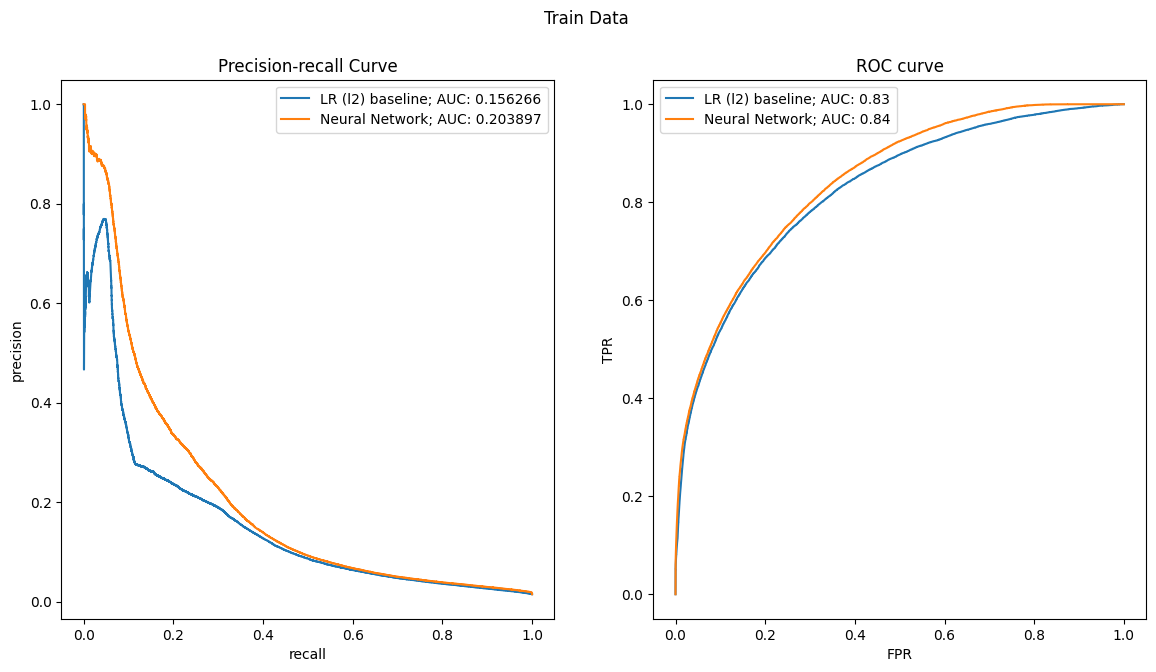

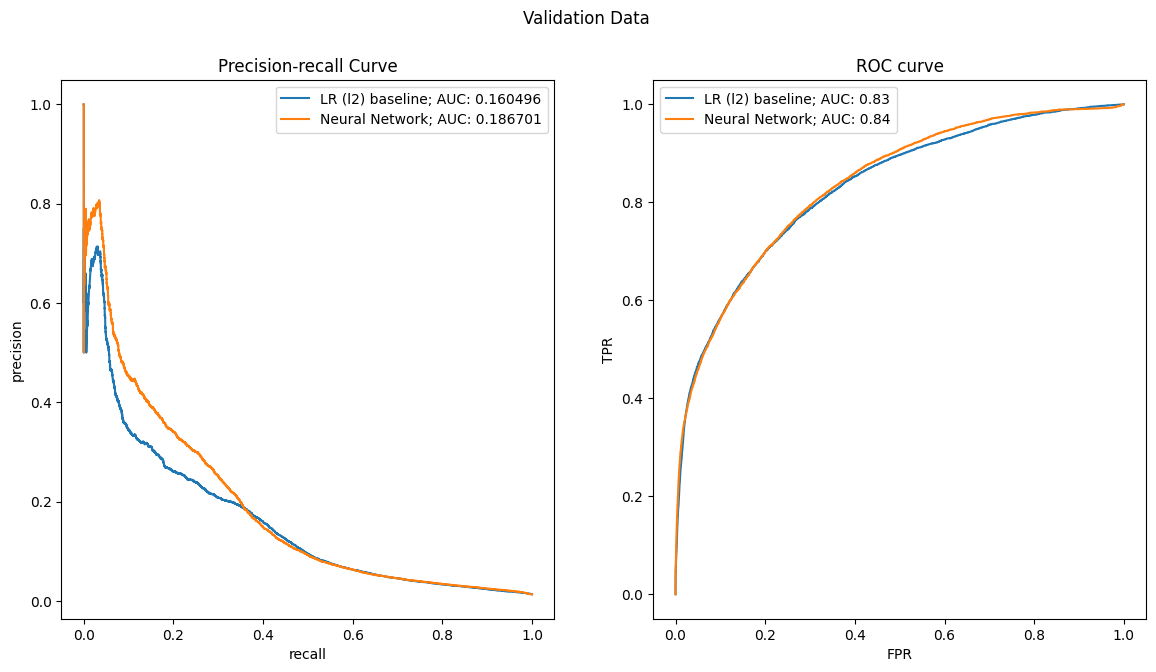

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[columns_train])
X_validation_scaled = scaler.transform(X_validation[columns_train])

def create_model():
    input_shape = (X_train[columns_train].shape[1],) 
    model = Sequential([
        tf.keras.layers.Input(shape=input_shape),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

model_NN = create_model()
model_NN.fit(X_train_scaled, y_train, epochs=15, batch_size=256, verbose=1)

y_train_pred_NN = model_NN.predict(X_train_scaled).ravel()
y_validation_pred_NN = model_NN.predict(X_validation_scaled).ravel()

fig6, ax6 = plt.subplots(1, 2, figsize=(14, 7))
fig6.suptitle("Train Data")
fig7, ax7 = plt.subplots(1, 2, figsize=(14, 7))
fig7.suptitle("Validation Data")

plot_metrics("LR (l2) baseline",y_pred=y_train_pred_baseline, y_test=y_train, figure = (fig6, ax6))
plot_metrics("LR (l2) baseline",y_pred=y_validation_pred_baseline, y_test=y_validation, figure = (fig7, ax7))
plot_metrics("Neural Network", y_pred=y_train_pred_NN, y_test=y_train, figure=(fig6, ax6))
plot_metrics("Neural Network", y_pred=y_validation_pred_NN, y_test=y_validation, figure=(fig7, ax7))


La red neuronal mejora en algunos puntos el modelo, sobre todo en precision-recall.

# 3. Categorical Encoding

Lo probamos con los modelos que hemos visto que mejor funcionan en cada caso.

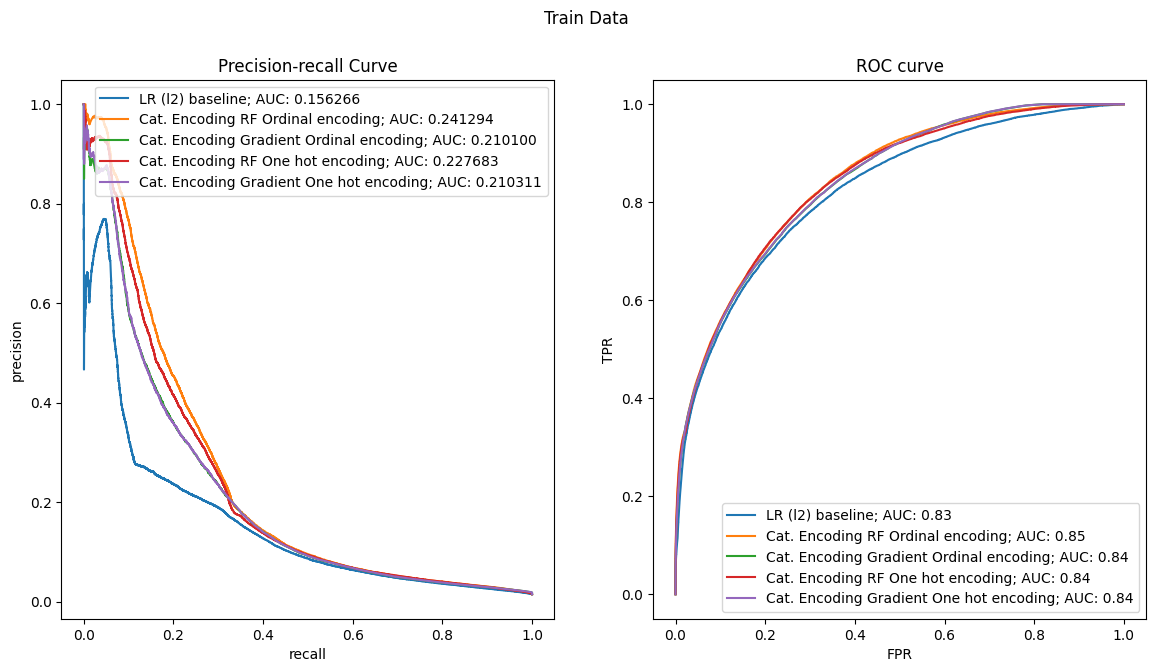

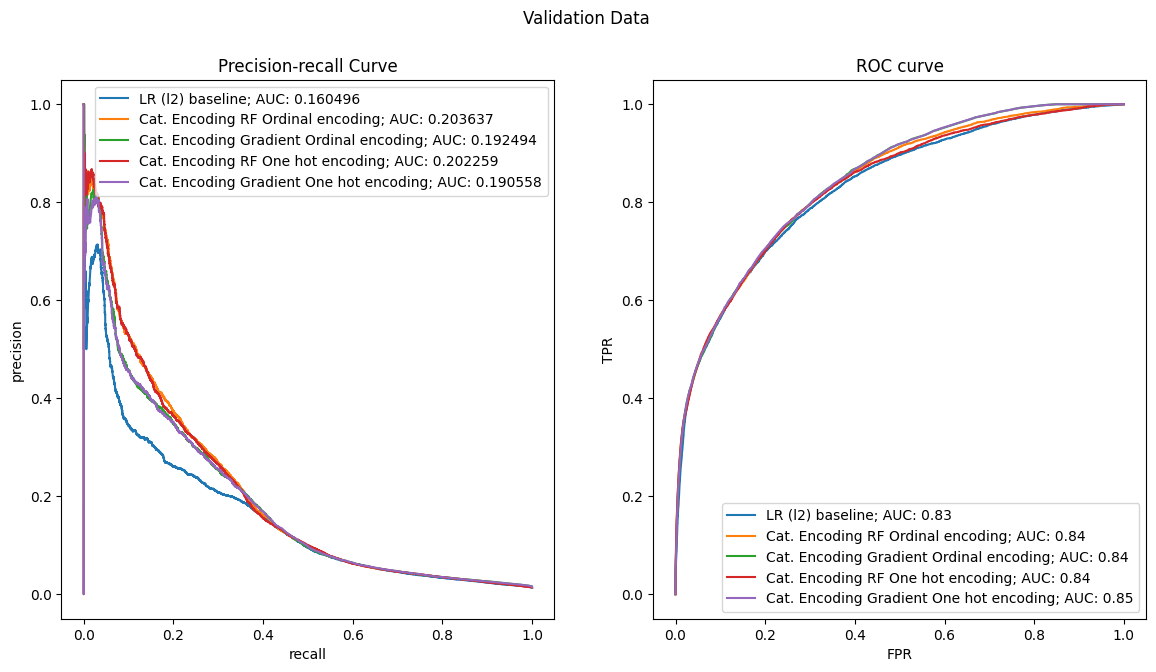

In [46]:
fig8, ax8 = plt.subplots(1, 2, figsize=(14, 7))
fig8.suptitle("Train Data")
fig9, ax9 = plt.subplots(1, 2, figsize=(14, 7))
fig9.suptitle("Validation Data")
plot_metrics("LR (l2) baseline",y_pred=y_train_pred_baseline, y_test=y_train, figure = (fig8, ax8))
plot_metrics("LR (l2) baseline",y_pred=y_validation_pred_baseline, y_test=y_validation, figure = (fig9, ax9))

cols_cat_enc = columns_train + label_cols
label_encoder = LabelEncoder()
Ordinal_Encoder = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
One_Hot_Encoder = OneHotEncoder(handle_unknown="ignore", max_categories=20)

categorical_processors = [
    Ordinal_Encoder,
    One_Hot_Encoder   
]
labels_CE = ["Ordinal encoding", "One hot encoding"]

for i, cat_processor in enumerate(categorical_processors):
    preporcessor = ColumnTransformer(
        [
            ("numerical", "passthrough", columns_train),
            ("categorical", cat_processor, label_cols),
        ]
    )
    model_CE_RF = make_pipeline(
        preporcessor,
        StandardScaler(),
        RandomForestClassifier(n_estimators=150, max_depth=10)
    )
    model_CE_RF.fit(X_train[cols_cat_enc], y_train)

    y_pred_CE = model_CE_RF.predict_proba(X_train[cols_cat_enc])[:, 1]
    plot_metrics(f"Cat. Encoding RF {labels_CE[i]}", y_pred = y_pred_CE, y_test = y_train, figure = (fig8, ax8))

    y_pred_CE = model_CE_RF.predict_proba(X_validation[cols_cat_enc])[:, 1]
    plot_metrics(f"Cat. Encoding RF {labels_CE[i]}", y_pred = y_pred_CE, y_test = y_validation, figure = (fig9, ax9))

    model_CE_GD = make_pipeline(
        preporcessor,
        StandardScaler(),
        GradientBoostingClassifier(
                n_estimators=25,
                max_depth=5)
    )
    model_CE_GD.fit(X_train[cols_cat_enc], y_train)
    
    y_pred_CE = model_CE_GD.predict_proba(X_train[cols_cat_enc])[:, 1]
    plot_metrics(f"Cat. Encoding Gradient {labels_CE[i]}", y_pred = y_pred_CE, y_test = y_train, figure = (fig8, ax8))

    y_pred_CE = model_CE_GD.predict_proba(X_validation[cols_cat_enc])[:, 1]
    plot_metrics(f"Cat. Encoding Gradient {labels_CE[i]}", y_pred = y_pred_CE, y_test = y_validation, figure = (fig9, ax9))


El modelo que mantenemos, por ser el que mejor predice, de los que hemos entrenado, es el Random Forest con ```depth = 10, trees = 150```, haciendo además categórical encoding (one hot encoder). Es el que uso en los códigos de producción.  